## Load HIV dataset

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [28]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [29]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [30]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Sampling 

In [31]:
# Separate the dataframe into three categories
df_CI = df[df['activity'] == 'CI']
df_CM = df[df['activity'] == 'CM']
df_CA = df[df['activity'] == 'CA']

# Sampling from each category
sample_CI = df_CI.sample(n=1100, random_state=42) 
sample_CM = df_CM.sample(n=800, random_state=42)
sample_CA = df_CA.sample(n=300, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# Shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_sf

,smiles,activity,HIV_active
0,[N-]=[N+]=CC(=O)CCC(=O)N(c1ccccc1)c1ccccc1,CM,1
1,NC(=S)Nc1nc(S)nc2[nH]ccc12,CM,1
2,CC(=NNc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])c1ccc...,CM,1
3,CC1(C)CC(=O)C2=C(C1)NC(SSC1=C(C#N)C(c3ccc(F)cc...,CM,1
4,O=C(O)c1ccc(-n2[se]c3ccccc3c2=O)cc1,CM,1
...,...,...,...
2195,O=C(Nc1ccccc1)c1cc(S(=O)(=O)Nc2n[nH]c(=O)n2-c2...,CM,1
2196,CN(C)c1ccc(S(=O)c2ccc(N(C)C)cc2)cc1,CI,0
2197,Cc1ccc(C)c(NC(=O)CCC(=NNC(=O)c2c(O)ccc3ccccc23...,CM,1
2198,Cc1ccc(S(=O)(=O)c2ccccn2)cc1,CM,1


[N-]=[N+]=CC(=O)CCC(=O)N(c1ccccc1)c1ccccc1


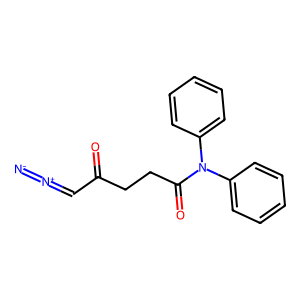

In [32]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx

smiles = sampled_sf['smiles'].iloc[0]
print(smiles)

# Visualizing the first molecule's structure as an example
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)

## Transform SMILES into Graph representation

In [33]:
from torch_geometric.data import Data

# Atom and bond preprocessing functions
def atom_features(atom):
    return [
        atom.GetAtomicNum(),             # Atomic number
        atom.GetFormalCharge(),          # Formal charge
        atom.GetDegree(),                # Degree of the atom
        int(atom.GetHybridization()),    # Hybridization
        atom.GetIsAromatic(),            # Aromaticity
        atom.GetImplicitValence(),       # Implicit valence
        atom.GetMass(),                  # Atomic mass 
        atom.GetTotalDegree(),           # Total number of bonds
        atom.GetTotalValence(),          # Total valence electrons
    ]

def bond_features(bond):
    bt = bond.GetBondType()
    return [
        int(bt == Chem.rdchem.BondType.SINGLE),
        int(bt == Chem.rdchem.BondType.DOUBLE),
        int(bt == Chem.rdchem.BondType.TRIPLE),
        int(bt == Chem.rdchem.BondType.AROMATIC),
        bond.GetIsConjugated(),  # Conjugation
        bond.IsInRing(),         # Whether the bond is in a ring
    ]

In [34]:
def normalize_features(features, max_length):
    """Normalize feature list to a specific length dynamically."""
    padded_features = []
    feature_length = len(features[0])  # assuming all features initially have the same length
    target_length = max_length * feature_length

    for feature in features:
        current_length = len(feature)
        if current_length < target_length:
            # Pad the feature if it is shorter than the target length
            feature.extend([0] * (target_length - current_length))
        elif current_length > target_length:
            # Cut the feature if it is longer than the target length
            feature = feature[:target_length]
        padded_features.append(feature)

    # Flatten the list of features to create a single list
    flat_features = [item for sublist in padded_features for item in sublist]
    return flat_features[:target_length]


In [35]:
def smiles_to_graph(smiles, radius=2, max_neighbors=10):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    # Initialize fingerprints
    fingerprint_dict = {atom.GetIdx(): atom_features(atom) for atom in atoms}
    
    # Initialize bond features for both directions
    bond_feature_dict = {}
    for bond in bonds:
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        features = bond_features(bond)
        bond_feature_dict[(start_idx, end_idx)] = features
        bond_feature_dict[(end_idx, start_idx)] = features  # Ensure both directions are covered

    # Weisfeiler-Lehman iteration to update fingerprints
    for _ in range(radius):
        new_fingerprint_dict = {}
        for atom in atoms:
            idx = atom.GetIdx()
            neighbor_info = []
            for bond in atom.GetBonds():
                other_idx = bond.GetOtherAtomIdx(idx)
                bond_feat = bond_feature_dict[(idx, other_idx)]
                combined_features = fingerprint_dict[other_idx] + bond_feat
                neighbor_info.append(combined_features)
            # Normalize the length of fingerprints including the current node's features
            flat_fingerprint = normalize_features([fingerprint_dict[idx]] + neighbor_info, max_neighbors)
            new_fingerprint_dict[idx] = flat_fingerprint
        fingerprint_dict = new_fingerprint_dict

    # Convert fingerprints to tensors
    node_feats = [fingerprint_dict[atom.GetIdx()] for atom in atoms]
    if any(len(feat) != len(node_feats[0]) for feat in node_feats):
        raise ValueError("Inconsistent feature lengths detected")
    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # Prepare edge index and attributes
    edge_index = []
    edge_attr = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])
        edge_features = bond_feature_dict[(i, j)]
        edge_attr.extend([edge_features, edge_features])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr)




# Apply the function to your dataframe
sampled_sf['graph'] = sampled_sf['smiles'].apply(smiles_to_graph)
print(len(sampled_sf['graph'].iloc[1].x[0]))
sampled_sf

900


,smiles,activity,HIV_active,graph
0,[N-]=[N+]=CC(=O)CCC(=O)N(c1ccccc1)c1ccccc1,CM,1,"[(x, [tensor([ 7.0000, -1.0000, 1.0000, 3.00..."
1,NC(=S)Nc1nc(S)nc2[nH]ccc12,CM,1,"[(x, [tensor([ 7.0000, 0.0000, 3.0000, 3.00..."
2,CC(=NNc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])c1ccc...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
3,CC1(C)CC(=O)C2=C(C1)NC(SSC1=C(C#N)C(c3ccc(F)cc...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
4,O=C(O)c1ccc(-n2[se]c3ccccc3c2=O)cc1,CM,1,"[(x, [tensor([ 8.0000, 0.0000, 1.0000, 3.00..."
...,...,...,...,...
2195,O=C(Nc1ccccc1)c1cc(S(=O)(=O)Nc2n[nH]c(=O)n2-c2...,CM,1,"[(x, [tensor([ 8.0000, 0.0000, 1.0000, 3.00..."
2196,CN(C)c1ccc(S(=O)c2ccc(N(C)C)cc2)cc1,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
2197,Cc1ccc(C)c(NC(=O)CCC(=NNC(=O)c2c(O)ccc3ccccc23...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
2198,Cc1ccc(S(=O)(=O)c2ccccn2)cc1,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."


## GNN

In [36]:
for i, data in enumerate(sampled_sf['graph']):
    data.y = torch.tensor([sampled_sf['HIV_active'][i]], dtype=torch.long)
print(sampled_sf['graph'][0])

Data(x=[37, 900], edge_index=[2, 76], edge_attr=[76, 6], y=[1])


In [37]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader 

sampled_sf = sampled_sf.reset_index(drop=True)
# Split data into training and testing sets
train_dataset, val_dataset = train_test_split(sampled_sf['graph'].tolist(), test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [42]:
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Sequential
from torch_geometric.nn import GATConv
from torch.optim import Adam
from tqdm import tqdm
from torch.nn import BatchNorm1d
from torch_geometric.utils import scatter

class Layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Layer, self).__init__()
        self.linear = Linear(in_dim, out_dim)
        self.relu = ReLU()
        self.bn = BatchNorm1d(out_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATLayer, self).__init__()
        self.conv = GATConv(in_channels, out_channels, heads=1)
        self.bn = BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x_res = x  # 残差连接
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)
        x = x + x_res  # 添加残差连接
        return x

class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes):
        super().__init__()
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        self.message_passing = GATLayer(node_hidden_dim, node_hidden_dim)  # 使用GAT层
        self.readout = Linear(node_hidden_dim, num_classes)

    def forward(self, data):
        node_hidden = self.node_embed(data.x)
        node_hidden = self.message_passing(node_hidden, data.edge_index)
        graph_embeddings = scatter(node_hidden, data.batch, dim=0)
        out = self.readout(graph_embeddings)
        return out


In [51]:
from sklearn.metrics import confusion_matrix

class GNNTrainer:
    def __init__(self, model, batch_size=32, learning_rate=1e-3, epoch=10, l2=1e-5):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        
    def train(self, train_loader, draw_curve=True):  
        self.model.train()
        loss_func = nn.CrossEntropyLoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(train_loader, leave=False):
                self.optimizer.zero_grad()
                batch_pred = self.model(batch_data)  # Assume model handles the batch_data correctly
                batch_loss = loss_func(batch_pred, batch_data.y)
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.item())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
            plt.show()
        
        return batch_loss_list
    
    def evaluate(self, val_loader, draw_curve=True):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(val_loader, leave=False):
                batch_pred = self.model(batch_data)
                y_pred.extend(batch_pred.argmax(dim=1).cpu().numpy())
                y_true.extend(batch_data.y.cpu().numpy())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        accuracy = np.mean(y_true == y_pred)
        
        if draw_curve:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy

In [52]:
num_classes = 2  # HIV_active: 0 1
node_input_dim = sampled_sf['graph'][0].x.shape[1] 
edge_input_dim = sampled_sf['graph'][0].edge_attr.shape[1]  
node_hidden_dim = 64
edge_hidden_dim = 64
model = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes)

GraphNet - Number of parameters: 62338
Epoch: 0


Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


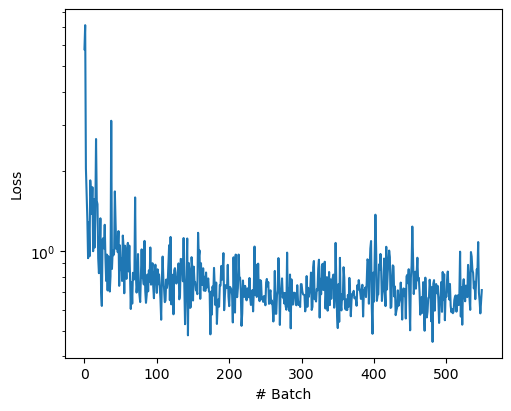

[5.7918381690979,
 7.139756202697754,
 2.0562846660614014,
 1.635104775428772,
 1.317253589630127,
 0.9405049681663513,
 1.2867974042892456,
 0.9559963941574097,
 1.850841760635376,
 1.6329855918884277,
 1.380993366241455,
 1.7440986633300781,
 0.9992502927780151,
 1.5728219747543335,
 1.0317356586456299,
 1.3665924072265625,
 2.6515495777130127,
 1.5492804050445557,
 1.5040587186813354,
 0.9397533535957336,
 0.8253331780433655,
 0.9732218384742737,
 1.3304409980773926,
 0.6987943649291992,
 0.6207900643348694,
 1.1068248748779297,
 1.12015700340271,
 1.0238642692565918,
 1.2574899196624756,
 0.9420580267906189,
 0.7711297273635864,
 0.970281720161438,
 0.7102698087692261,
 0.9574283957481384,
 0.8814718127250671,
 0.7035593390464783,
 0.8038012981414795,
 3.1078245639801025,
 0.8563857674598694,
 1.0055019855499268,
 0.9643753170967102,
 0.9899526238441467,
 1.6810933351516724,
 1.2756255865097046,
 1.0197954177856445,
 1.099072813987732,
 0.9906073808670044,
 1.1903458833694458,
 0.7

In [53]:
trainer = GNNTrainer(model)
trainer.train(train_loader)

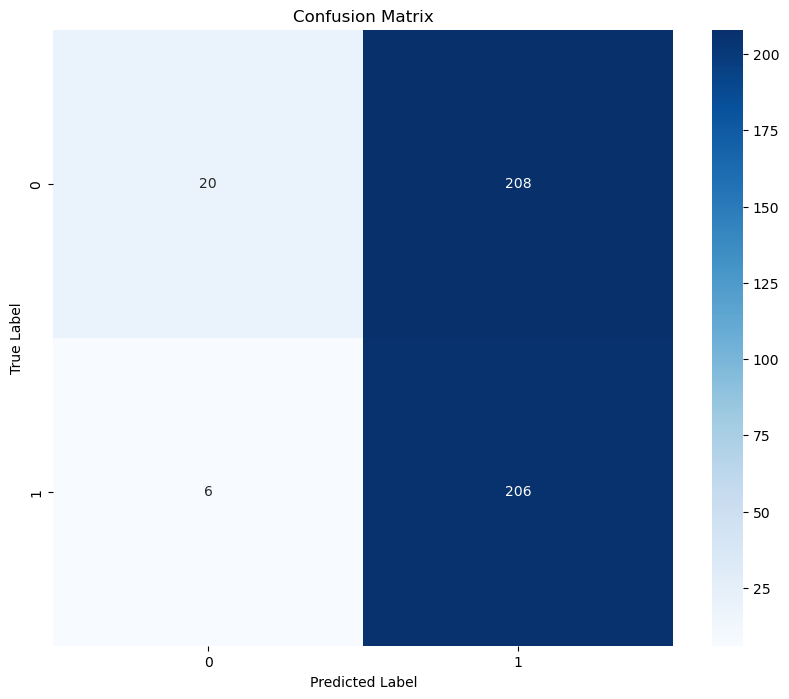

0.5136363636363637

In [54]:
# evaulate
trainer.evaluate(val_loader)